In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
cabbage_df = pd.read_excel("data-files/양배추_가격.xlsx", engine='openpyxl')

In [64]:
cabbage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7229 entries, 0 to 7228
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DATE     7229 non-null   object 
 1   거래단위     7229 non-null   object 
 2   평균가격     7229 non-null   object 
 3   총거래물량    7229 non-null   float64
 4   총거래금액    7229 non-null   int64  
 5   도매시장     7229 non-null   object 
 6   도매법인     7229 non-null   object 
 7   품목       7229 non-null   object 
 8   품종       7229 non-null   object 
 9   산지-광역시도  7229 non-null   object 
 10  산지-시군구   7229 non-null   object 
 11  등급       7229 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 677.8+ KB


In [65]:
cabbage_df['산지-시군구'].unique()

array(['충청남도', '서산시', '제주시', '삼척시', '무안군', '전라남도', '해남군', '김천시', '진해시',
       '춘천시', '전라북도', '단양군', '중구', '정선군', '고창군', '서울특별시', '-', '당진시',
       '거제시', '청주시', '송파구', '괴산군', '평창군', '진안군', '홍천군', '강서구', '태백시',
       '영양군', '진도군', '전주시', '남제주군', '횡성군', '부산광역시', '북구', '북제주군', '포항시',
       '익산시', '태안군', '창원시', '무주군', '천안시', '고양시', '부안군', '예산군', '원주시',
       '완주군', '사상구', '완도군', '대전광역시', '봉화군', '임실군', '충주시', '강동구', '평택시',
       '장수군', '상주시', '고흥군', '강원도', '광주광역시', '강릉시', '영월군', '제주도', '경상북도',
       '청원군', '경기도', '대구광역시', '포천시', '청송군', '달성군', '안동시', '양구군', '김제시',
       '중국', '구리시', '공주시', '경상남도', '김해시', '제천시', '여주군', '보성군', '광양시',
       '보은군', '계룡시', '영암군', '파주시', '영광군', '김포시', '아산시', '담양군', '함안군',
       '영덕군', '경주시', '남원시', '화성시', '계양구', '남양주시', '정읍시', '창녕군', '순천시',
       '철원군', '안성시', '남해군', '음성군', '관악구', '서귀포시', '양주시', '안산시', '고성군',
       '영주시', '밀양시', '기장군', '서구', '광산구', '신안군', '목포시', '장흥군', '장성군', '동구',
       '나주시', '양평군', '남구', '홍성군', '구미시', '영동군', '수원시', '강진군', '부여군',
  

In [66]:
cabbage_df['도매시장'].unique()

array(['구리도매시장', '인천구월도매', '순천도매시장', '수원도매시장', '안양도매시장', '서울강서도매',
       '광주각화도매', '창원내서도매시장', '원주도매시장', '부산반여도매', '전주도매시장', '천안도매시장',
       '안산도매시장', '창원팔용도매시장', '청주도매시장', '춘천도매시장', '대전노은도매', '대구북부도매',
       '광주서부도매', '포항도매시장', '부산엄궁도매', '강릉도매시장', '울산도매시장', '인천삼산도매',
       '정읍도매시장', '대전오정도매', '서울가락도매', '진주도매시장', '충주도매시장', '구미도매시장'],
      dtype=object)

In [67]:
cabbage_df['산지-광역시도'].unique()

array(['충청남도', '제주', '강원도', '전라남도', '전남', '충남', '경상북도', '경상남도', '강원',
       '전라북도', '충북', '부산', '전북', '서울특별시', '-', '경남', '서울', '충청북도',
       '부산광역시', '광주', '경북', '경기도', '대전광역시', '경기', '광주광역시', '제주도', '대구광역시',
       '인천', '중국', '대구', '울산', '울산광역시', '대전'], dtype=object)

In [ ]:
# 산지-광역시도 기준 디렉토리

region_sum = {
    '충남': '충청남도', 
    '강원': '강원도', 
    '제주':'제주도', 
    '전남' : '전라남도',
    '전북' : '전라북도', 
    '강원' : '강원도',
    '충북' : '충청북도',
    '부산' : '부산광역시',
    '경남' : '경상남도',
    '서울' : '서울특별시',
    '광주' : '광주광역시', 
    '경북' : '경상북도',
    '경기' : '경기도',
    '인천' : '인천광역시',
    '대구' : '대구광역시',
    '울산' : '울산광역시',
    '대전' : '대전광역시'
}

In [ ]:
# 시각화 하기 위해서 평균가격, 총거래물량, 도매시장, 산지-광역시도 컬럼만 가져오기

cabbage_df['평균가격'] = pd.to_numeric(cabbage_df['평균가격'], errors='coerce')
cabbage_df['총거래물량'] = pd.to_numeric(cabbage_df['총거래물량'], errors='coerce')


cabbage_df_cleaned = cabbage_df.dropna(subset=['평균가격', '총거래물량', '도매시장', '산지-광역시도'])


# 가중치
cabbage_df_cleaned['weighted_price'] = (
    cabbage_df_cleaned['평균가격'] * cabbage_df_cleaned['총거래물량']
)


# 산지-광역시도 데이터를 위에서 만든 기준 디렉토리를 이용하여 변경
# 충북 = 충청북도, 충남 = 충청남도 등

cabbage_df_cleaned['산지-광역시도'] = cabbage_df_cleaned['산지-광역시도'].replace(region_sum)


# 도매시장별로 그룹화
weighted_avg_market = (
    cabbage_df_cleaned.groupby(['DATE', '도매시장']).apply(
        lambda g: g['weighted_price'].sum() / g['총거래물량'].sum()
    ).reset_index(name='가중평균가격')
)

# 광역시도별로 그룹화
weighted_avg_ragion = (
    cabbage_df_cleaned.groupby(['DATE', '산지-광역시도'])
    .apply(lambda g: g['weighted_price'].sum() / g['총거래물량'].sum())
    .reset_index(name='가중평균가격')
)

C:\Users\human\AppData\Local\Temp\ipykernel_5072\4174360441.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cabbage_df_cleaned['weighted_price'] = (
C:\Users\human\AppData\Local\Temp\ipykernel_5072\4174360441.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cabbage_df_cleaned['산지-광역시도'] = cabbage_df_cleaned['산지-광역시도'].replace(region_sum)
C:\Users\human\AppData\Local\Temp\ipykernel_5072\4174360441.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is de

In [70]:
weighted_avg_market['도매시장'].unique()

array(['강릉도매시장', '광주각화도매', '광주서부도매', '구리도매시장', '구미도매시장', '대구북부도매',
       '대전노은도매', '부산반여도매', '부산엄궁도매', '서울강서도매', '수원도매시장', '순천도매시장',
       '안산도매시장', '울산도매시장', '원주도매시장', '인천구월도매', '전주도매시장', '진주도매시장',
       '창원내서도매시장', '창원팔용도매시장', '천안도매시장', '춘천도매시장', '포항도매시장', '서울가락도매',
       '대전오정도매', '충주도매시장', '인천삼산도매', '청주도매시장', '안양도매시장', '정읍도매시장'],
      dtype=object)

<Figure size 1400x800 with 0 Axes>

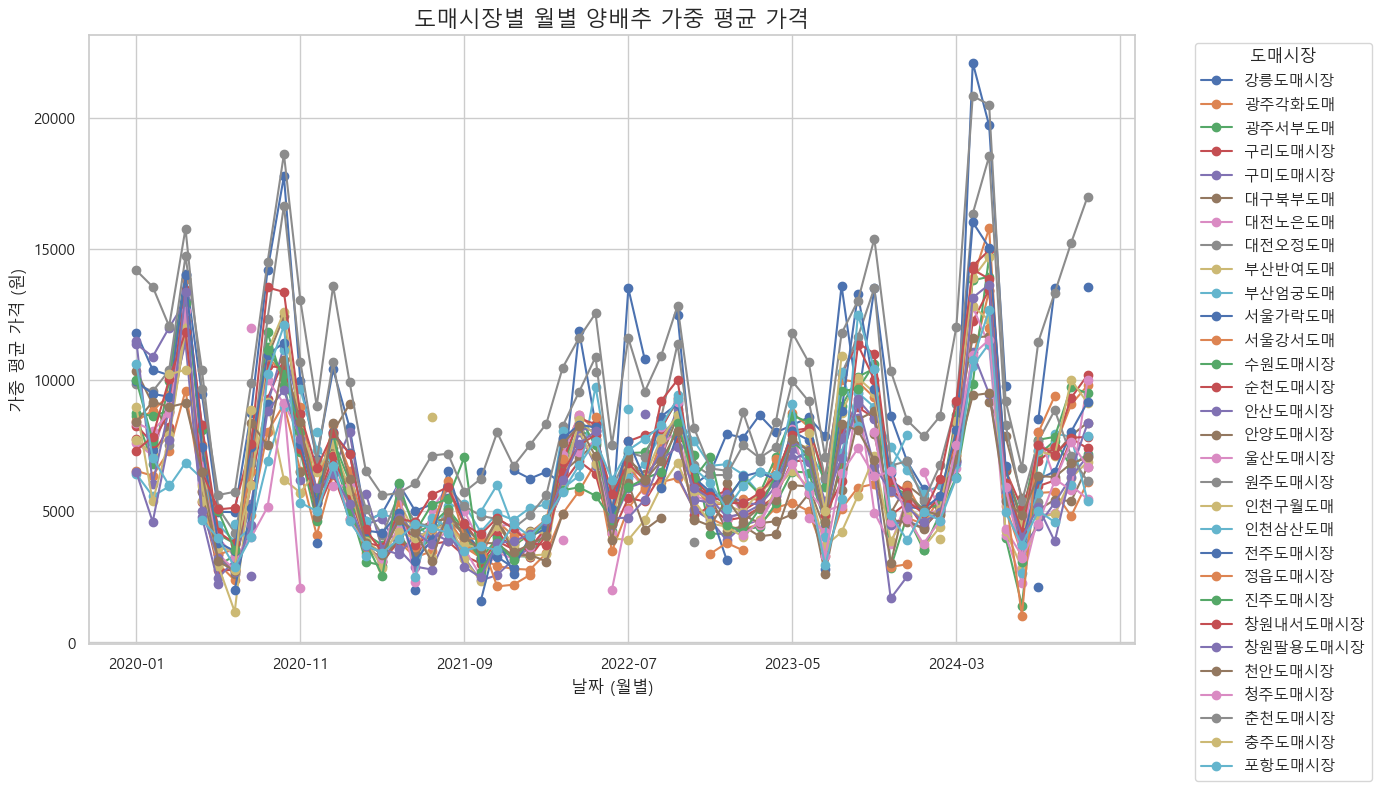

In [ ]:
#도매시장별 월별 가격 시각화

import matplotlib.pyplot as plt

#한글
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False


cabbage_market_pivot = weighted_avg_market.pivot(index='DATE', columns='도매시장', values='가중평균가격')

plt.figure(figsize=(14, 8))
cabbage_market_pivot.plot(kind='line', figsize=(14, 8), marker='o')

plt.title('도매시장별 월별 양배추 가중 평균 가격', fontsize=16)
plt.xlabel('날짜 (월별)', fontsize=12)
plt.ylabel('가중 평균 가격 (원)', fontsize=12)
plt.grid(True)
plt.legend(title='도매시장', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [73]:
cabbage_df_cleaned['산지-광역시도'].unique()

array(['충청남도', '제주도', '강원도', '전라남도', '경상북도', '경상남도', '전라북도', '충청북도',
       '부산광역시', '서울특별시', '-', '광주광역시', '경기도', '대전광역시', '대구광역시', '인천광역시',
       '중국', '울산광역시'], dtype=object)

<Figure size 1400x800 with 0 Axes>

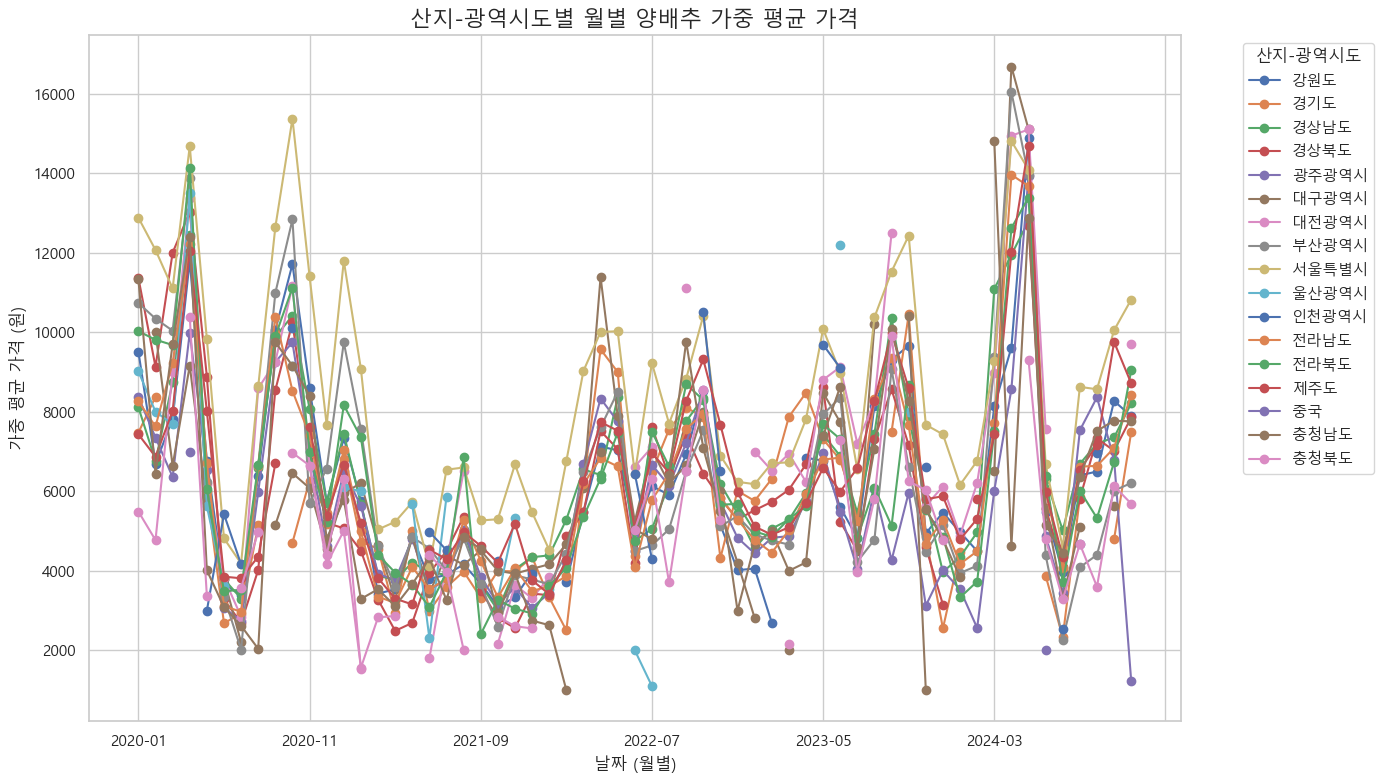

In [ ]:
#광역시도별 월별 가격시각화

import matplotlib.pyplot as plt

#한글
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

weighted_avg_ragion = weighted_avg_ragion[weighted_avg_ragion['산지-광역시도'] != '-']

cabbage_ragion_pivot = weighted_avg_ragion.pivot(index='DATE', columns='산지-광역시도', values='가중평균가격')

plt.figure(figsize=(14, 8))
cabbage_ragion_pivot.plot(kind='line', figsize=(14, 8), marker='o')

plt.title('산지-광역시도별 월별 양배추 가중 평균 가격', fontsize=16)
plt.xlabel('날짜 (월별)', fontsize=12)
plt.ylabel('가중 평균 가격 (원)', fontsize=12)
plt.grid(True)
plt.legend(title='산지-광역시도', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# cabbage_df_cleaned.to_csv("data-files/cabbage_df_cleaned.csv", index=False)

In [ ]:
# 기후 데이터 가져오기

weather_final = pd.read_csv("data-files/weather_final.csv")

In [88]:
weather_final

,광역시도,평균기온,평균풍속,평균강수량,DATE
0,강원도,-3.48,2.06,2.07,2019-01-01
1,강원도,-1.12,1.82,22.44,2019-02-01
2,강원도,4.30,2.18,41.57,2019-03-01
3,강원도,9.15,2.13,55.95,2019-04-01
4,강원도,16.84,2.24,18.88,2019-05-01
...,...,...,...,...,...
1193,충청북도,22.34,1.27,118.63,2024-06-01
1194,충청북도,25.83,1.41,449.82,2024-07-01
1195,충청북도,27.35,1.10,67.85,2024-08-01
1196,충청북도,23.90,1.08,233.70,2024-09-01
